In [1]:
# Basic imports
import os, torch, numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda



=== TRAIN DATASET ===
cat: 10000 images
dog: 10000 images

=== VAL DATASET ===
cat: 2500 images
dog: 2500 images


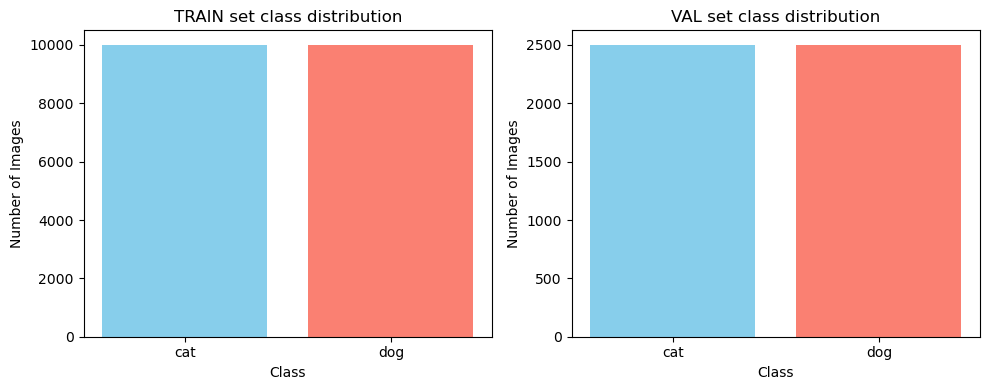

In [2]:
# Set your dataset root folder
dataset_path = r"C:\Users\ADMIN\Downloads\datasets\datasets"

splits = ['train', 'val']  # we usually check only these two
class_counts = {}

for split in splits:
    split_path = os.path.join(dataset_path, split)
    classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    
    class_counts[split] = {}
    for cls in classes:
        class_dir = os.path.join(split_path, cls)
        count = len([
            f for f in os.listdir(class_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        class_counts[split][cls] = count

# Print results
for split, counts in class_counts.items():
    print(f"\n=== {split.upper()} DATASET ===")
    for cls, count in counts.items():
        print(f"{cls}: {count} images")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i, split in enumerate(splits):
    axes[i].bar(class_counts[split].keys(), class_counts[split].values(), color=['skyblue', 'salmon'])
    axes[i].set_title(f"{split.upper()} set class distribution")
    axes[i].set_xlabel("Class")
    axes[i].set_ylabel("Number of Images")

plt.tight_layout()
plt.show()

In [3]:
# Load pretrained ResNet weights (for transforms)
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()  # ensures correct resize & normalization

# Dataset paths
train_dir = r'C:/Users/ADMIN/Downloads/datasets/datasets/train'
val_dir   = r'C:/Users/ADMIN/Downloads/datasets/datasets/val'

# Build datasets
train_ds = datasets.ImageFolder(train_dir, transform=preprocess)
val_ds   = datasets.ImageFolder(val_dir,   transform=preprocess)

# Data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train classes: {train_ds.classes}")
print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")


Train classes: ['cat', 'dog']
Train samples: 20000, Val samples: 5000


#In summary, weights.transforms() does:

#Resize image → 232 pixels (short side)

#Center crop → 224×224 pixels

#Convert to tensor → shape (3,224,224) in [0,1]

#Normalize → using ImageNet mean & std

#This keeps your dataset consistent with the pretrained model’s expected input format.

In [4]:
# Load pretrained ResNet18
model = resnet18(weights=weights)

# Freeze all convolutional layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final FC layer (2 classes: dog vs cat)
num_feats = model.fc.in_features
model.fc = nn.Linear(num_feats, 2)

model = model.to(device)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
#🧩 4️⃣ Define Loss Function and Optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=3e-3, weight_decay=1e-4)

In [7]:
def accuracy_from_logits(logits, targets):
    return (logits.argmax(dim=1) == targets).float().mean().item()

def train_one_epoch(model, loader):
    model.train()
    total_loss, total_acc, n = 0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        bs = yb.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, yb) * bs
        n += bs
    return total_loss/n, total_acc/n

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, total_acc, n = 0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        bs = yb.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, yb) * bs
        n += bs
    return total_loss/n, total_acc/n


In [29]:
# 🧩 6️⃣ Train the Model

🧩 8️⃣ Visualize Predictions (Sanity Check)

In [30]:
from PIL import Image
import glob
import numpy as np

idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}
model.load_state_dict(torch.load("resnet18_best.pt", map_location=device))
model.eval()

sample_paths = []
for cls in train_ds.classes:
    sample_paths += glob.glob(f"{val_dir}/{cls}/*")[:3]

def predict_one(img_path):
    img = Image.open(img_path).convert("RGB")
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze().cpu().numpy()
    pred = np.argmax(probs)
    return idx_to_class[pred], probs

for path in sample_paths:
    pred, probs = predict_one(path)
    print(os.path.basename(path), "→", pred, "(confidence:", round(np.max(probs), 3), ")")


cat.100.jpg → cat (confidence: 1.0 )
cat.1000.jpg → cat (confidence: 1.0 )
cat.10000.jpg → cat (confidence: 1.0 )
dog.1.jpg → dog (confidence: 1.0 )
dog.1000.jpg → dog (confidence: 1.0 )
dog.10008.jpg → dog (confidence: 1.0 )


In [31]:
EPOCHS = 20
best_val_acc = 0

# ✅ Create lists to store metrics per epoch
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    va_loss, va_acc = evaluate(model, val_loader)

    # Store metrics
    train_loss_list.append(tr_loss)
    val_loss_list.append(va_loss)
    train_acc_list.append(tr_acc)
    val_acc_list.append(va_acc)

    print(f"Epoch {epoch:02d} | Train loss {tr_loss:.4f} acc {tr_acc:.3f} | Val loss {va_loss:.4f} acc {va_acc:.3f}")
    
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), "resnet18_best.pt")
        print("  ✅ Saved best model")

print("Best Validation Accuracy:", best_val_acc)


Epoch 01 | Train loss 0.0031 acc 0.999 | Val loss 0.0922 acc 0.986
  ✅ Saved best model
Epoch 02 | Train loss 0.0006 acc 1.000 | Val loss 0.0928 acc 0.987
  ✅ Saved best model
Epoch 03 | Train loss 0.0006 acc 1.000 | Val loss 0.1261 acc 0.983
Epoch 04 | Train loss 0.0009 acc 1.000 | Val loss 0.1082 acc 0.987
Epoch 05 | Train loss 0.0002 acc 1.000 | Val loss 0.1088 acc 0.987
  ✅ Saved best model
Epoch 06 | Train loss 0.0015 acc 1.000 | Val loss 0.1242 acc 0.985
Epoch 07 | Train loss 0.0014 acc 1.000 | Val loss 0.1209 acc 0.986
Epoch 08 | Train loss 0.0012 acc 1.000 | Val loss 0.1270 acc 0.987
  ✅ Saved best model
Epoch 09 | Train loss 0.0022 acc 0.999 | Val loss 0.1277 acc 0.986
Epoch 10 | Train loss 0.0003 acc 1.000 | Val loss 0.1251 acc 0.987
Epoch 11 | Train loss 0.0006 acc 1.000 | Val loss 0.1355 acc 0.985
Epoch 12 | Train loss 0.0012 acc 1.000 | Val loss 0.1381 acc 0.987
Epoch 13 | Train loss 0.0011 acc 1.000 | Val loss 0.1343 acc 0.986
Epoch 14 | Train loss 0.0018 acc 1.000 | Val 

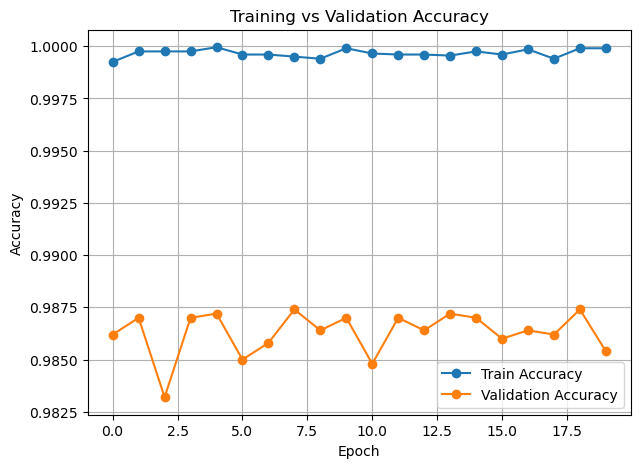

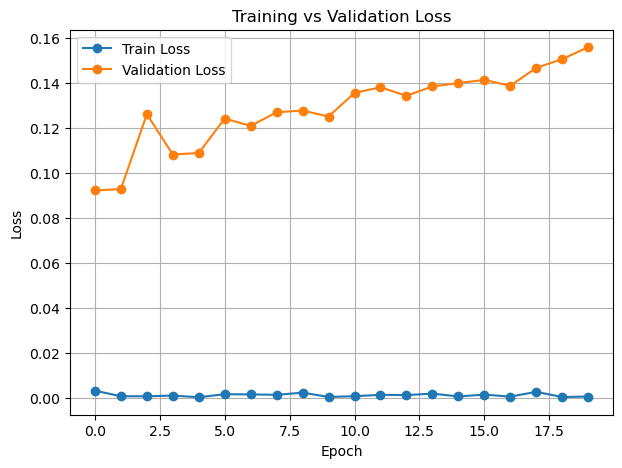

In [33]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(7,5))
plt.plot(train_acc_list, label='Train Accuracy', marker='o')
plt.plot(val_acc_list, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(7,5))
plt.plot(train_loss_list, label='Train Loss', marker='o')
plt.plot(val_loss_list, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make sure model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in val_loader:  # or test_loader if you have one
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


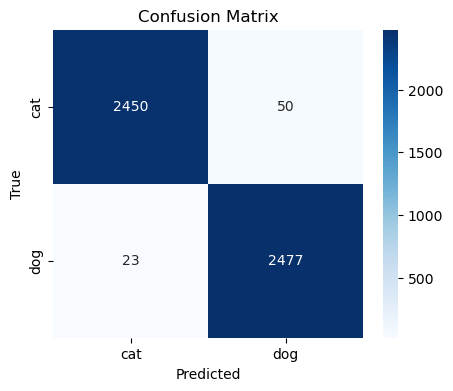

In [35]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get class names from dataset
class_names = list(val_ds.classes)  # e.g., ['cat', 'dog']

# Plot with seaborn heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [1]:
#Testing

✅ Saved results to test_predictions_with_gt.csv
  filename  true_id  pred_id pred_name  confidence
0    1.jpg        0        0       cat         1.0
1    2.jpg        0        0       cat         1.0
2    3.jpg        0        0       cat         1.0
3    4.jpg        1        1       dog         1.0
4    5.jpg        1        1       dog         1.0

🔢 Test Accuracy: 97.80%

📋 Classification Report:
              precision    recall  f1-score   support

      cat(0)     0.9833    0.9711    0.9771       242
      dog(1)     0.9732    0.9845    0.9788       258

    accuracy                         0.9780       500
   macro avg     0.9782    0.9778    0.9780       500
weighted avg     0.9781    0.9780    0.9780       500



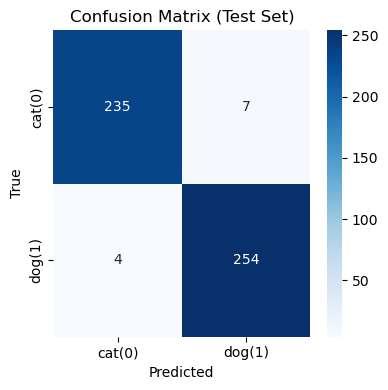

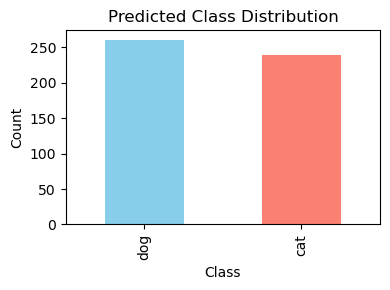

In [41]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- CONFIG ---
test_dir = r"C:\Users\ADMIN\Downloads\datasets\datasets\test"          # unlabeled test images (1.jpg, 2.jpg, ...)
gt_csv   = r"C:\Users\ADMIN\Downloads\datasets\datasets\testClassification.csv"  # self-labeled file
class_names = ['cat', 'dog']  # 0 = cat, 1 = dog

# --- LOAD ground truth ---
gt = pd.read_csv(gt_csv, header=None, names=['filename', 'true_id'])
# ensure filename column has .jpg extension
gt['filename'] = gt['filename'].astype(str) + ".jpg"

# --- PREDICT using your trained model ---
model.eval()

rows = []
for _, row in gt.iterrows():
    fname = row['filename']
    img_path = os.path.join(test_dir, fname)
    if not os.path.exists(img_path):
        print("⚠️ Missing:", img_path)
        continue

    img = Image.open(img_path).convert("RGB")
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_id = int(np.argmax(probs))
        conf = float(np.max(probs))
    rows.append({
        "filename": fname,
        "true_id": row['true_id'],
        "pred_id": pred_id,
        "pred_name": class_names[pred_id],
        "confidence": round(conf, 4)
    })

# --- SAVE RESULTS ---
df = pd.DataFrame(rows)
df.to_csv("test_predictions_with_gt.csv", index=False)
print("✅ Saved results to test_predictions_with_gt.csv")
print(df.head())

# --- METRICS ---
y_true = df["true_id"]
y_pred = df["pred_id"]

acc = accuracy_score(y_true, y_pred)
print(f"\n🔢 Test Accuracy: {acc*100:.2f}%")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["cat(0)", "dog(1)"], digits=4))

# --- CONFUSION MATRIX ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["cat(0)", "dog(1)"],
            yticklabels=["cat(0)", "dog(1)"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

# --- PREDICTION DISTRIBUTION ---
plt.figure(figsize=(4,3))
df['pred_name'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title('Predicted Class Distribution')
plt.xlabel('Class'); plt.ylabel('Count')
plt.tight_layout(); plt.show()
